# Work with (remote) ome zarr

One of the cool things about ome-zarr files is, that it does not make a difference whether a file is stored locally or remotely. This means you can work with ome-zarr files stored on the web, in cloud storage or on your local disk using the same code.

In [12]:
import ngff_zarr as nz
import matplotlib.pyplot as plt
import dask.array as da
from skimage import filters

```{note}
In the below example, `url` is a link to aremote path,
but it may as well be a local path, e.g. `path = r'C:\data\my_image.ome.zarr'`.
```

In [4]:
url = r'https://s3.zih.tu-dresden.de/joso140h:2309xx23ds/cells3d.ome.zarr/'

ngff_image = nz.from_ngff_zarr(url)
ngff_image

Multiscales(images=[NgffImage(data=dask.array<from-zarr, shape=(2, 60, 256, 256), dtype=uint16, chunksize=(1, 15, 128, 128), chunktype=numpy.ndarray>, dims=['c', 'z', 'y', 'x'], scale={'c': 1.0, 'z': 0.5, 'y': 0.5, 'x': 0.5}, translation={'c': 0.0, 'z': 0.0, 'y': 0.0, 'x': 0.0}, name='image', axes_units={'c': None, 'z': None, 'y': None, 'x': None}, axes_orientations=None, computed_callbacks=[]), NgffImage(data=dask.array<from-zarr, shape=(2, 30, 128, 128), dtype=uint16, chunksize=(1, 15, 64, 128), chunktype=numpy.ndarray>, dims=['c', 'z', 'y', 'x'], scale={'c': 1.0, 'z': 1.0, 'y': 1.0, 'x': 1.0}, translation={'c': 0.0, 'z': 0.25, 'y': 0.25, 'x': 0.25}, name='image', axes_units={'c': None, 'z': None, 'y': None, 'x': None}, axes_orientations=None, computed_callbacks=[]), NgffImage(data=dask.array<from-zarr, shape=(2, 15, 64, 64), dtype=uint16, chunksize=(2, 15, 64, 64), chunktype=numpy.ndarray>, dims=['c', 'z', 'y', 'x'], scale={'c': 1.0, 'z': 2.0, 'y': 2.0, 'x': 2.0}, translation={'c': 

## Visualizing remote data

Let's look at some of the raw data in the highest-resolution level of the ome-zarr object.

In [6]:
ngff_image.images[0].data

dask.array<from-zarr, shape=(2, 60, 256, 256), dtype=uint16, chunksize=(1, 15, 128, 128), chunktype=numpy.ndarray>

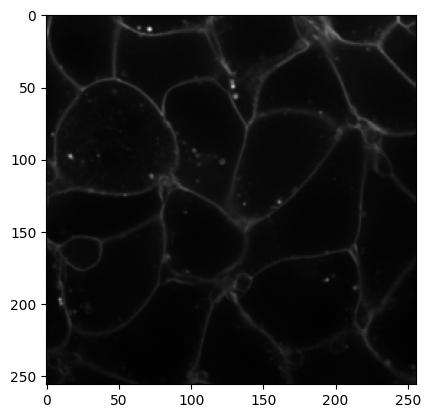

In [7]:
fig, ax = plt.subplots()
ax.imshow(ngff_image.images[0].data[0, 30, :, :], cmap='gray')

All of this works without having to download any of the data on our local disk!
Let's try this with a bigger dataset stored remotely:

In [9]:
url = r'https://s3.zih.tu-dresden.de/joso140h:2309xx23ds/20250721_selectedPos_1_Focus_Plane_order2_1.ome.zarr/'

ngff_image = nz.from_ngff_zarr(url)
ngff_image.images[0].data

dask.array<from-zarr, shape=(23560, 21253), dtype=uint16, chunksize=(737, 1329), chunktype=numpy.ndarray>

This is almost 1 GB of data and we can still access it *lazily* over the network without downloading the entire dataset.
Let's visualize a part of it using matplotlib.

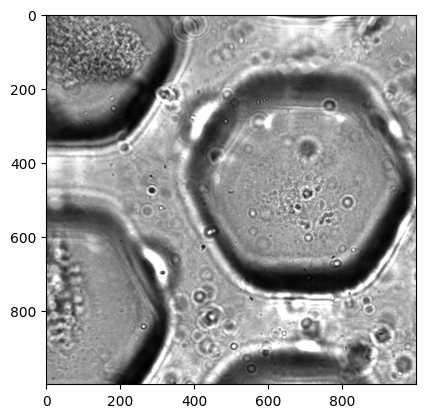

In [15]:
fig, ax = plt.subplots()
ax.imshow(ngff_image.images[0].data[5000:6000, 5000:6000], cmap='gray')

## Processing

Viewing is one thing, but in practice we much rather need to process (filter, segment, etc) images.
Surely we'll have to load the data locally for that, right?
Luckily, dask in conjunction with remote, lazily loaded ome-zarr data gives us a way out.

We can observe two things:
- the operation executes *blazingly fast* because no data is loaded yet
- the resulting `filtered_image` is a dask array

In [22]:
def threshold_otsu(image):
    from skimage.filters import threshold_otsu
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary
binarized = da.map_blocks(threshold_otsu, ngff_image.images[0].data)
binarized

dask.array<threshold_otsu, shape=(23560, 21253), dtype=bool, chunksize=(737, 1329), chunktype=numpy.ndarray>

Let's look at the output of `binarized` to confirm this.

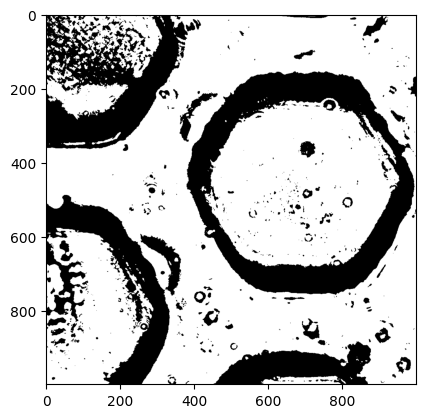

In [23]:
fig, ax = plt.subplots()
ax.imshow(binarized[5000:6000, 5000:6000], cmap='gray')